# Ensemble Methods

Decision Trees, Random Forest, and Bagging will be looked at to see if these methods can produce decent output without the need to use imbalance sampling techniques. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import imblearn
import sklearn
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_graphviz, export_text
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedBaggingClassifier, EasyEnsembleClassifier, BalancedRandomForestClassifier, RUSBoostClassifier
from sklearn.metrics import recall_score, precision_recall_curve, precision_score
from sklearn.model_selection import KFold, RandomizedSearchCV, GridSearchCV, train_test_split

In [2]:
dummy_df = pd.read_parquet('../../../Data/dummy-term-deposit-marketing.parquet')
dummy_df.head()

,age,default,balance,housing,loan,day,campaign,y,duration_minutes,job_admin,...,month_aug,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct
0,58,0,2143,1,0,5,1,0,4.350000,False,...,False,False,False,False,False,False,False,True,False,False
1,44,0,29,1,0,5,1,0,2.516667,False,...,False,False,False,False,False,False,False,True,False,False
2,33,0,2,1,1,5,1,0,1.266667,False,...,False,False,False,False,False,False,False,True,False,False
3,35,0,231,1,0,5,1,0,2.316667,False,...,False,False,False,False,False,False,False,True,False,False
4,28,0,447,1,1,5,1,0,3.616667,False,...,False,False,False,False,False,False,False,True,False,False


In [3]:
dummy_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38335 entries, 0 to 38334
Data columns (total 40 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age                  38335 non-null  int8   
 1   default              38335 non-null  int8   
 2   balance              38335 non-null  int32  
 3   housing              38335 non-null  int8   
 4   loan                 38335 non-null  int8   
 5   day                  38335 non-null  int8   
 6   campaign             38335 non-null  int8   
 7   y                    38335 non-null  int8   
 8   duration_minutes     38335 non-null  float64
 9   job_admin            38335 non-null  bool   
 10  job_blue-collar      38335 non-null  bool   
 11  job_entrepreneur     38335 non-null  bool   
 12  job_housemaid        38335 non-null  bool   
 13  job_management       38335 non-null  bool   
 14  job_retired          38335 non-null  bool   
 15  job_self-employed    38335 non-null 

In [4]:
for col in dummy_df.columns:
    if dummy_df[col].dtype=='bool':
        dummy_df[col] = dummy_df[col].astype('category')

In [5]:
non_demographic_features = [
    'day',
    'campaign',
    'duration_minutes',
    'contact_unknown',
    'contact_telephone',
    'contact_cellular',
    'month_jan',
    'month_feb',
    'month_mar',
    'month_apr',
    'month_may',
    'month_jun',
    'month_jul',
    'month_aug',
    'month_oct',
    'month_nov',
    'month_dec'
]

In [6]:
X = dummy_df.iloc[:, ~dummy_df.columns.isin(non_demographic_features)]
X.head()

,age,default,balance,housing,loan,y,job_admin,job_blue-collar,job_entrepreneur,job_housemaid,...,job_services,job_student,job_technician,job_unemployed,marital_divorced,marital_married,marital_single,education_primary,education_secondary,education_tertiary
0,58,0,2143,1,0,0,False,False,False,False,...,False,False,False,False,False,True,False,False,False,True
1,44,0,29,1,0,0,False,False,False,False,...,False,False,True,False,False,False,True,False,True,False
2,33,0,2,1,1,0,False,False,True,False,...,False,False,False,False,False,True,False,False,True,False
3,35,0,231,1,0,0,False,False,False,False,...,False,False,False,False,False,True,False,False,False,True
4,28,0,447,1,1,0,False,False,False,False,...,False,False,False,False,False,False,True,False,False,True


In [7]:
y = dummy_df['y'].values
X = dummy_df.drop('y', axis=1)

In [8]:
seed = 4701

X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=seed, shuffle=True, train_size=.80
)

In [9]:
def return_scores(estimator, X_train, X_test, y_train, y_test):
    estimator = estimator
    train_score = estimator.score(X_train, y_train)
    test_score = estimator.score(X_test, y_test)

    train_pred = estimator.predict(X_train)
    test_pred = estimator.predict(X_test)

    train_recall = recall_score(y_train, estimator.predict(X_train))
    test_recall = recall_score(y_test, estimator.predict(X_test))

    train_prec = precision_score(y_train, train_pred)
    test_prec = precision_score(y_test, test_pred)

    df = pd.DataFrame({
        # 'Accuracy': [train_score, test_score],
        'Recall': [train_recall, test_recall],
        'Precision': [train_prec, test_prec]
    }, index=['Train', 'Test'])

    return df

## Tree and Ensemble Method Experimentation

Since Pycaret did not allow for ensemble methods to test with for imbalance techniques this notebook will experiment with base tree and ensemble methods and then different imbalanced tree and ensemble methods.

In [10]:
fold = KFold(5, shuffle=True, random_state=seed)

c = [len(test) for (train, test) in fold.split(X_train, y_train)]

In [11]:
import math
from math import ceil

#### max_depth for decsion tree and random forest
max_max_depth = ceil(np.log2(c[0]))
print(f"Maximum Max-depth: {max_max_depth}")

#### m = square root of p predictors
max_features = ceil(np.sqrt(len(X_train.columns)))
print(f"Max features: {max_features}")

Maximum Max-depth: 13
Max features: 7


In [ ]:
dt = DecisionTreeClassifier(random_state=seed, max_depth=max_max_depth)
bc = RandomForestClassifier(random_state=seed, n_estimators=1000, max_features=max_features, n_jobs=-1)
rf = RandomForestClassifier(random_state=seed, n_estimators=1000, max_depth=max_max_depth, n_jobs=-1)

In [85]:
preds = []
probs = []

for model in [dt, bc, rf]:

    if model.__class__.__name__ == 'RandomForestClassifier':
        if model.max_features is not None and model.max_features != 'sqrt':
            print("Model: BaggingClassifier")
        else:
            print("Model: RandomForestClassifier")
    else:
        print(f"Model: {model.__class__.__name__}")

    model = model
    model.fit(X_train, y_train)

    preds_ = model.predict(X_test)
    probs_ = model.predict_proba(X_test)[:, 1]

    preds.append(preds_)
    probs.append(probs_)

    print(return_scores(model, X_train, X_test, y_train, y_test))
    print()

Model: DecisionTreeClassifier


         Recall  Precision
Train  0.721851   0.893172
Test   0.396330   0.516746

Model: BaggingClassifier
        Recall  Precision
Train  1.00000   1.000000
Test   0.32844   0.621528

Model: RandomForestClassifier
         Recall  Precision
Train  0.546061   0.987128
Test   0.200000   0.644970



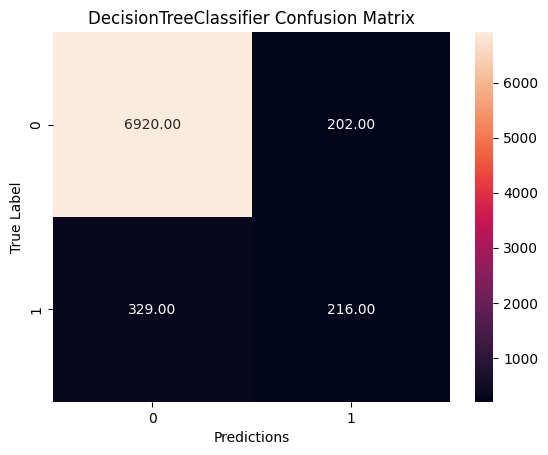

Total time saved using DecisionTreeClassifier: 476.09 hours


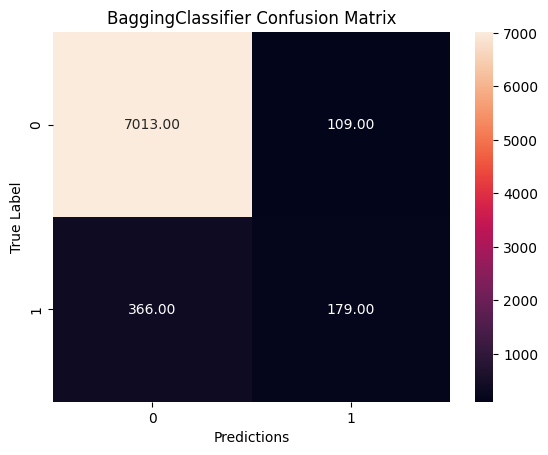

Total time saved using BaggingClassifier: 489.27 hours


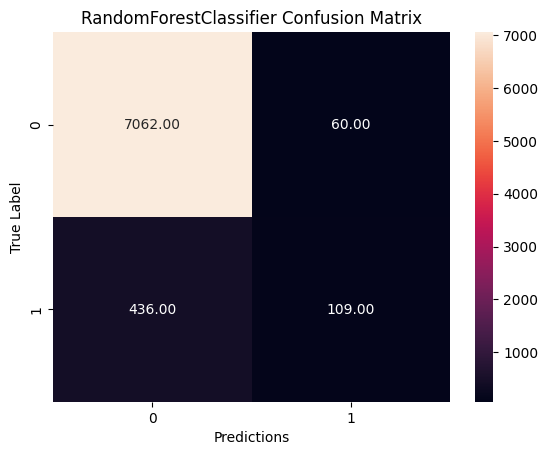

Total time saved using RandomForestClassifier: 496.21 hours


In [86]:
from sklearn.metrics import confusion_matrix

duration_total = dummy_df['duration_minutes'].sum()/60 ## call time in hours for whole campaign

duration_mean = dummy_df['duration_minutes'].mean() ## average minutes per customer

for (model, pred, prob) in list(zip([dt, bc, rf], preds, probs)):
    if model.__class__.__name__ == 'RandomForestClassifier':
        if model.max_features is not None and model.max_features != 'sqrt':
            model = "BaggingClassifier"
        else:
            model = "RandomForestClassifier"
    else:
        model = model.__class__.__name__


    conf_matrix = confusion_matrix(y_test, pred)

    sns.heatmap(conf_matrix, annot=True, fmt='.2f')
    plt.xlabel('Predictions')
    plt.ylabel('True Label')
    plt.title(f"{model} Confusion Matrix")
    plt.show()

    true_negs = conf_matrix[0][0]*duration_mean/60 ## true negative hours

    false_pos = conf_matrix[0][1]*duration_mean/60 ## false positive hours

    time_saved = round(true_negs - false_pos, 2)

    print(f"Total time saved using {model}: {time_saved} hours")

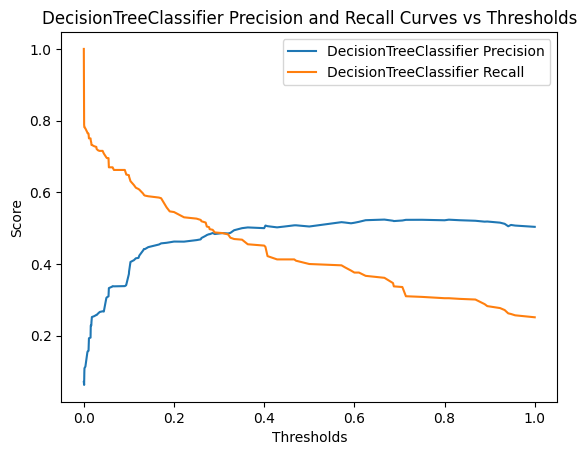

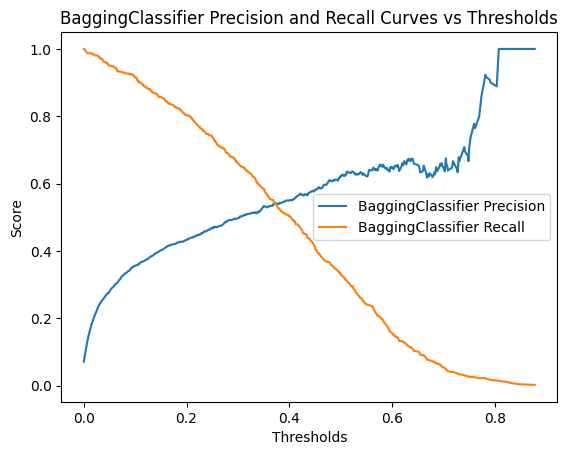

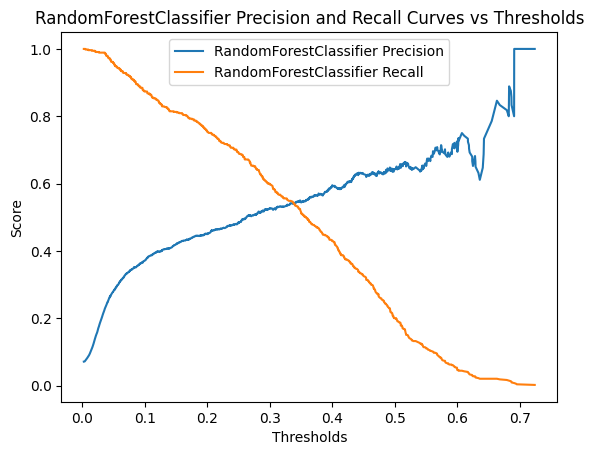

In [88]:
precision_scores = []
recall_scores = []
thresholds = []

for (model, prob) in list(zip([dt, bc, rf], probs)):

    if model.__class__.__name__ == 'RandomForestClassifier':
        if model.max_features is not None and model.max_features != 'sqrt':
            model = "BaggingClassifier"
        else:
            model = "RandomForestClassifier"
    else:
        model = model.__class__.__name__

    precsion, recall, thresholds_ = precision_recall_curve(y_test, prob)

    precision_scores.append(precsion)
    recall_scores.append(recall)
    thresholds.append(thresholds_)

    plt.plot(thresholds_, precsion[:-1], label=f'{model} Precision')
    plt.plot(thresholds_, recall[:-1], label=f'{model} Recall')
    plt.xlabel('Thresholds')
    plt.ylabel('Score')
    plt.legend()
    plt.title(f"{model} Precision and Recall Curves vs Thresholds")
    plt.show()

In [ ]:
plt.plot(precision[0], recall[0], label='DecisionTree')
plt.plot(precision[1], recall[1], label='BaggingClassifier')
plt.plot(precision[2], recall[2], label='RandomForest')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.title(f"Precision vs Recall Curve")
plt.show()

## Balanced Ensemble Classifiers

In [100]:
eec = EasyEnsembleClassifier(random_state=seed, n_jobs=-1)
bbc = BalancedBaggingClassifier(random_state=seed, n_jobs=-1)
brf = BalancedRandomForestClassifier(random_state=seed, n_jobs=-1)
rus_boost = RUSBoostClassifier(random_state=seed)

In [101]:
bal_preds = []
bal_probs = []

for model in [eec, bbc, brf, rus_boost]:

    print(f"Model: {model.__class__.__name__}")

    model = model
    model.fit(X_train, y_train)

    preds = model.predict(X_test)
    probs = model.predict_proba(X_test)[:, 1]

    bal_preds.append(preds)
    bal_probs.append(probs)

    print(return_scores(model, X_train, X_test, y_train, y_test))
    print()

Model: EasyEnsembleClassifier


         Recall  Precision
Train  0.828660   0.332559
Test   0.827523   0.318728

Model: BalancedBaggingClassifier
         Recall  Precision
Train  0.986204   0.455873
Test   0.856881   0.379366

Model: BalancedRandomForestClassifier
         Recall  Precision
Train  1.000000   0.432115
Test   0.888073   0.366945

Model: RUSBoostClassifier
         Recall  Precision
Train  0.695594   0.342238
Test   0.673394   0.321366



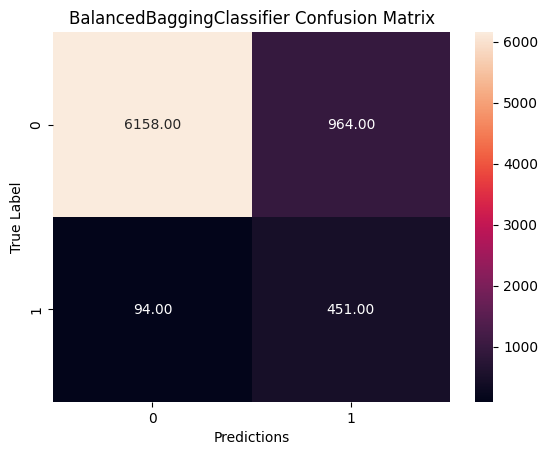

Total time saved using BalancedBaggingClassifier: 368.08 hours


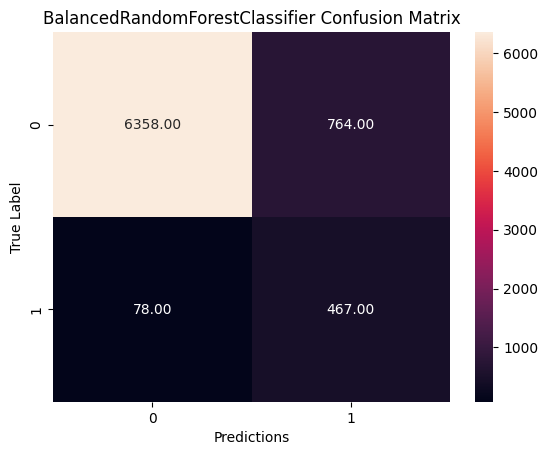

Total time saved using BalancedRandomForestClassifier: 396.43 hours


In [102]:
times_saved = []

for (model, pred, prob) in list(zip([bbc, brf], bal_preds, bal_probs)):
    model = model.__class__.__name__

    conf_matrix = confusion_matrix(y_test, pred)

    sns.heatmap(conf_matrix, annot=True, fmt='.2f')
    plt.xlabel('Predictions')
    plt.ylabel('True Label')
    plt.title(f"{model} Confusion Matrix")
    plt.show()

    true_negs = conf_matrix[0][0]*duration_mean/60 ## true negative hours

    false_pos = conf_matrix[0][1]*duration_mean/60 ## false positive hours

    time_saved = round(true_negs - false_pos, 2)

    times_saved.append(time_saved)

    print(f"Total time saved using {model}: {time_saved} hours")

From the initial precision and recall scores we can see the out-of-the-box BalancedBagging and BalancedRandomForest classifiers are performing the best.

We will tune the max_features and max_depth of the RandomForest classifier next to see if improvements can be made.

## Balanced Random Forest Classifier

In [105]:
brf_for_tuning = BalancedRandomForestClassifier(random_state=seed, n_jobs=-1)

In [106]:
params = {
    'n_estimators': np.arange(100,5000,150),
    'max_features': np.arange(2,max_features)
}

grid = RandomizedSearchCV(
    estimator=brf_for_tuning,
    param_distributions=params,
    cv=KFold(shuffle=True, random_state=seed),
    random_state=seed,
    scoring=['recall', 'precision'],
    n_jobs=-1,
    refit=False,
    return_train_score=True
)

grid.fit(X_train, y_train)

RandomizedSearchCV(cv=KFold(n_splits=5, random_state=4701, shuffle=True),
                   estimator=BalancedRandomForestClassifier(n_jobs=-1,
                                                            random_state=4701),
                   n_jobs=-1,
                   param_distributions={'max_features': array([2, 3, 4, 5, 6]),
                                        'n_estimators': array([ 100,  250,  400,  550,  700,  850, 1000, 1150, 1300, 1450, 1600,
       1750, 1900, 2050, 2200, 2350, 2500, 2650, 2800, 2950, 3100, 3250,
       3400, 3550, 3700, 3850, 4000, 4150, 4300, 4450, 4600, 4750, 4900])},
                   random_state=4701, refit=False, return_train_score=True,
                   scoring=['recall', 'precision'])

In [107]:
params_list = sorted(list(
    zip(
        grid.cv_results_['param_n_estimators'].tolist(),
        grid.cv_results_['param_max_features'].tolist()
        )
    )
)

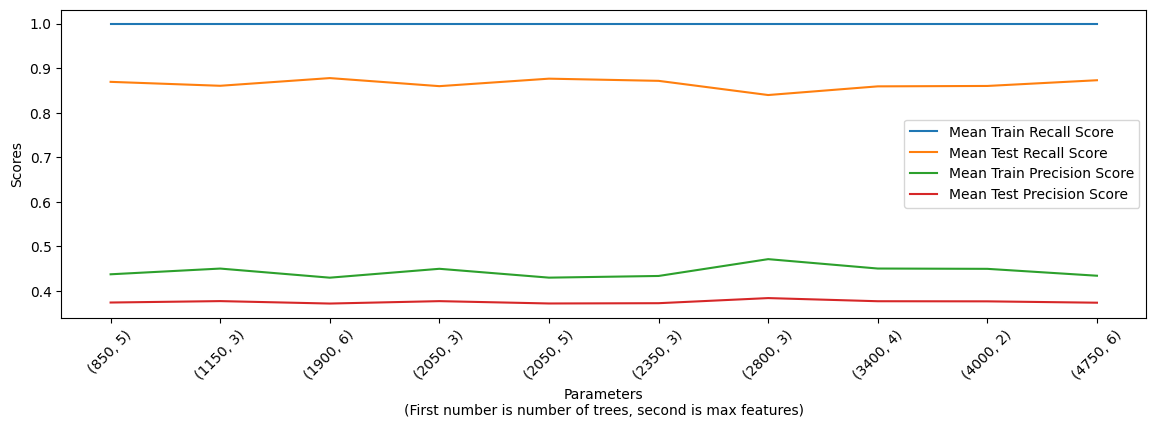

In [108]:
plt.figure(figsize=(14,4))
plt.plot(np.arange(len(params_list)), grid.cv_results_['mean_train_recall'], label='Mean Train Recall Score')
plt.plot(np.arange(len(params_list)), grid.cv_results_['mean_test_recall'], label='Mean Test Recall Score')
plt.plot(np.arange(len(params_list)), grid.cv_results_['mean_train_precision'], label='Mean Train Precision Score')
plt.plot(np.arange(len(params_list)), grid.cv_results_['mean_test_precision'], label='Mean Test Precision Score')
plt.ylabel('Scores')
plt.xlabel('Parameters\n(First number is number of trees, second is max features)')
plt.xticks(np.arange(len(params_list)), labels=params_list, rotation=45)
plt.legend()
plt.show()

In [109]:
brf_tuned = BalancedRandomForestClassifier(n_estimators=1000,
                                      max_features=max_features,
                                      n_jobs=-1,
                                      random_state=seed)

brf_tuned.fit(X_train, y_train)

BalancedRandomForestClassifier(max_features=7, n_estimators=1000, n_jobs=-1,
                               random_state=4701)

In [110]:
brf_preds = brf_tuned.predict(X_test)
brf_probs = brf_tuned.predict_proba(X_test)[:, 1]

return_scores(brf_tuned, X_train, X_test, y_train, y_test)

,Recall,Precision
Train,1.000000,0.427105
Test,0.891743,0.362957


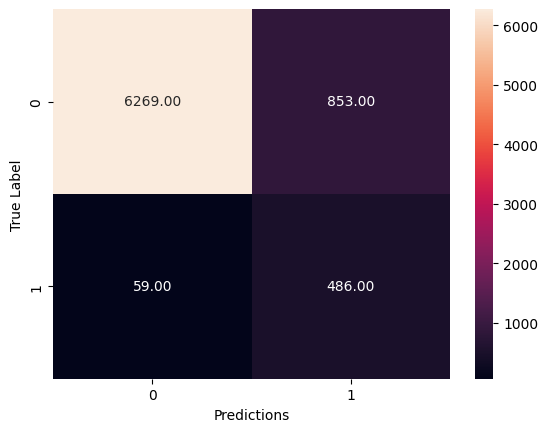

In [111]:
brf_conf_matrix = confusion_matrix(y_test, brf_preds)

sns.heatmap(brf_conf_matrix, annot=True, fmt='.2f')
plt.xlabel('Predictions')
plt.ylabel('True Label')
plt.show()

In [112]:
brf_tuned_true_negs = brf_conf_matrix[0][0]*duration_mean/60 ## true negative hours

brf_tuned_false_pos = brf_conf_matrix[0][1]*duration_mean/60 ## false positive hours

brf_tuned_time_saved = round(brf_tuned_true_negs - brf_tuned_false_pos, 2)

print(f"Total time saved using balanced random forest technique:        {times_saved[1]} hours")
print(f"Total time saved using tuned balanced random forest technique:  {brf_tuned_time_saved} hours")

Total time saved using balanced random forest technique:        396.43 hours
Total time saved using tuned balanced random forest technique:  383.82 hours


After tuning the balancedrandomforest classifier we see that it classifies more customers than the out-of-the-box model but has a slightly lower precision score. Resulting in a better model than the LinearSVC model.

## Whole Dataset Modeling

In [113]:
dummy_df.head()

,age,default,balance,housing,loan,day,campaign,y,duration_minutes,job_admin,...,month_aug,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct
0,58,0,2143,1,0,5,1,0,4.350000,False,...,False,False,False,False,False,False,False,True,False,False
1,44,0,29,1,0,5,1,0,2.516667,False,...,False,False,False,False,False,False,False,True,False,False
2,33,0,2,1,1,5,1,0,1.266667,False,...,False,False,False,False,False,False,False,True,False,False
3,35,0,231,1,0,5,1,0,2.316667,False,...,False,False,False,False,False,False,False,True,False,False
4,28,0,447,1,1,5,1,0,3.616667,False,...,False,False,False,False,False,False,False,True,False,False


In [114]:
y = dummy_df['y'].values
X = dummy_df.drop('y', axis=1)
X.head()

,age,default,balance,housing,loan,day,campaign,duration_minutes,job_admin,job_blue-collar,...,month_aug,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct
0,58,0,2143,1,0,5,1,4.350000,False,False,...,False,False,False,False,False,False,False,True,False,False
1,44,0,29,1,0,5,1,2.516667,False,False,...,False,False,False,False,False,False,False,True,False,False
2,33,0,2,1,1,5,1,1.266667,False,False,...,False,False,False,False,False,False,False,True,False,False
3,35,0,231,1,0,5,1,2.316667,False,False,...,False,False,False,False,False,False,False,True,False,False
4,28,0,447,1,1,5,1,3.616667,False,False,...,False,False,False,False,False,False,False,True,False,False


In [115]:
X_train_whole, X_test_whole, y_train_whole, y_test_whole = train_test_split(
    X, y, random_state=seed, train_size=.80, shuffle=True
)

In [116]:
balanced_rf_whole = BalancedRandomForestClassifier(n_estimators=1000,
                                                    max_features=max_features,
                                                    n_jobs=-1,
                                                    random_state=seed).fit(X_train_whole, y_train_whole)

In [117]:
whole_preds = balanced_rf_whole.predict(X_test_whole)

return_scores(balanced_rf_whole, X_train_whole, X_test_whole, y_train_whole, y_test_whole)

,Recall,Precision
Train,1.000000,0.427105
Test,0.891743,0.362957


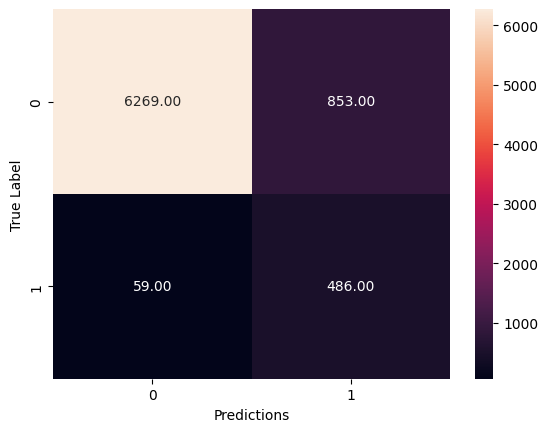

In [119]:
balanced_rf_whole_conf_matrix = confusion_matrix(y_test_whole, whole_preds)

sns.heatmap(balanced_rf_whole_conf_matrix, annot=True, fmt='.2f')
plt.xlabel('Predictions')
plt.ylabel('True Label')
plt.show()

In [120]:
brf_whole_tuned_true_negs = balanced_rf_whole_conf_matrix[0][0]*duration_mean/60 ## true negative hours

brf_whole_tuned_false_pos = balanced_rf_whole_conf_matrix[0][1]*duration_mean/60 ## false positive hours

brf_whole_tuned_time_saved = round(brf_whole_tuned_true_negs - brf_whole_tuned_false_pos, 2)

print(f"Total time saved using tuned balanced random forest technique:  {brf_whole_tuned_time_saved} hours")

Total time saved using tuned balanced random forest technique:  383.82 hours
